https://github.com/dpmlab/Anticipation-of-temporally-structured-events/blob/8fbd488c04d47148f9a53048de5d05a90e1c1663/s_light.py#L311

# Import Libraries

In [1]:
import os
import pickle
import numpy as np
import deepdish as dd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import pearsonr
from brainiak.eventseg.event import EventSegment
from sklearn.model_selection import train_test_split
import nibabel as nib

from scipy.stats import ttest_ind
from scipy.stats import pearsonr, ttest_1samp
from statsmodels.stats.multitest import multipletests

from nilearn import plotting, image
from nibabel.viewers import OrthoSlicer3D

/home/nalzahli/miniforge3/envs/buda/lib/python3.7/site-packages/nilearn/__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


# 2D Maps (repeat, vox)

In [6]:
def create_2d_vox_map(sl_timescales):

    # Number of valid voxels
    non_nan_mask = nib.load('../data/valid_vox.nii').get_fdata().T > 0
    coords = np.transpose(np.where(non_nan_mask))
    nVox = coords.shape[0]

    nMaps = 6  # Number of movie repeats

    # Indices of voxels belonging to each searchlight
    SL_voxels = pickle.load(open('../data/SL/SL_allvox.p', 'rb'))

    # Arrays for voxel maps and voxel searchlight count
    vox_map_2d = np.zeros((nMaps, nVox))
    voxel_SLcount = np.zeros(nVox)

    # Iterate over searchlights and voxels
    for sl_idx, voxels_per_sl in enumerate(SL_voxels):
        for m in range(nMaps):
            vox_map_2d[m, voxels_per_sl] += sl_timescales[str(sl_idx)][m] # voxel gets all its sl contributions

        # Increment the count of searchlights for each voxel
        voxel_SLcount[voxels_per_sl] += 1

    # Identify non-zero voxel counts
    nz_vox = voxel_SLcount > 0

    # Calculate voxel means based on searchlight contributions
    vox_map_2d[:, nz_vox] = vox_map_2d[:, nz_vox] / voxel_SLcount[nz_vox]

    # Set values for voxels with no searchlight contribution to NaN
    vox_map_2d[:, ~nz_vox] = np.nan

    return vox_map_2d

# 4D Maps (X,Y,Z,repeat)

In [ ]:
def create_4d_vox_map(vox_map_2d):

    non_nan_mask = nib.load('../data/valid_vox.nii').get_fdata().T > 0
    X,Y,Z = non_nan_mask.shape

    vox_map_4d = np.zeros((Z,Y,X,6))
    vox_map_4d[non_nan_mask] = vox_map_2d.T

    return vox_map_4d

# One vs. Other

In [3]:
def one_vs_other(vox_map_4d, template):

    # The first voxel map for movie repeat #1
    group1 = vox_map_4d[:,:,:,0]

    # Average of the rest of the voxel maps for movie repeats [2,6]
    group2 = np.mean(vox_map_4d[:,:,:,1:], axis = 3)

    OvO = group2 - group1

    OvO_img = nib.Nifti1Image(OvO.T, affine=template.affine, header=template.header)

    return OvO_img

# Correlation | timescales & range

In [4]:
def corr_timescales_range(vox_map_2d, template):

    non_nan_mask = nib.load('../data/valid_vox.nii').get_fdata().T > 0
    X,Y,Z = non_nan_mask.shape

    # Reference vector
    ref_vector = np.array([1, 2, 3, 4, 5, 6])

    # Initialize array to store the correlation coefficients
    correlation_map = np.zeros(vox_map_2d.shape[1])

    # Corr for each voxel
    for i in range(vox_map_2d.shape[1]):
        correlation_map[i], _ = pearsonr(vox_map_2d[:, i], ref_vector)

    # Reshape corr map back to 3D
    corr = np.zeros((Z,Y,X))
    corr[non_nan_mask] = correlation_map

    corr_img = nib.Nifti1Image(corr.T, affine=template.affine, header=template.header)

    return corr_img

# Intact

## LL

In [ ]:
# template
header_fpath = '../data/0407161_predtrw02/filtFuncMNI_Intact_Rep1.nii'
template = nib.load(header_fpath)

# load eWBC.npy file / dictionary 
sl_timescales = np.load('./intact_maps/LL/LL.npy', allow_pickle=True).item()

# create 2d voxel map [repeat, voxel]
vox_map_2d = create_2d_vox_map(sl_timescales)

# create 4d voxel map [Z,Y,X,repeat]
vox_map_4d = create_4d_vox_map(vox_map_2d)

# visualize maps
for i in range(6):
    img = nib.Nifti1Image(vox_map_4d[:,:,:,i].T, affine=template.affine, header=template.header)
    nib.save(img, f'./intact_maps/LL/LL_repeat{i}.nii')

    plotting.plot_img(img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)

# do one vs. other analysis
OvO_img = one_vs_other(vox_map_4d, template)
plotting.plot_img(OvO_img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)
nib.save(OvO_img , './intact_maps/LL/OvO_LL.nii')

# get correlations between voxel timescales and range[1,6]
corr_img = corr_timescales_range(vox_map_2d, template)
plotting.plot_img(corr_img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)
nib.save(corr_img, './intact_maps/LL/corr_LL.nii')

In [9]:
# template
header_fpath = '../data/0407161_predtrw02/filtFuncMNI_Intact_Rep1.nii'
template = nib.load(header_fpath)

# load eWBC.npy file / dictionary 
sl_timescales = np.load('./timescales/eLL.npy', allow_pickle=True).item()

In [10]:
# create 2d voxel map [repeat, voxel]
vox_map_2d = create_2d_vox_map(sl_timescales)

In [12]:
# create 4d voxel map [Z,Y,X,repeat]
vox_map_4d = create_4d_vox_map(vox_map_2d)

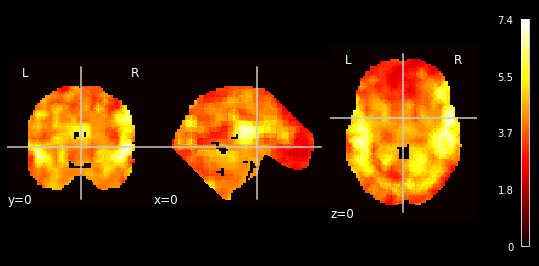

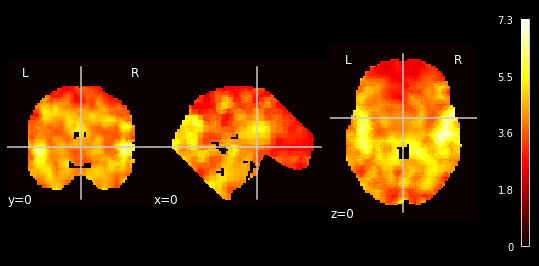

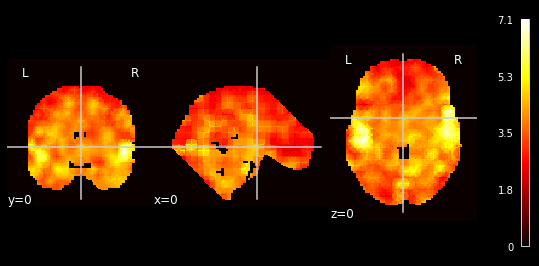

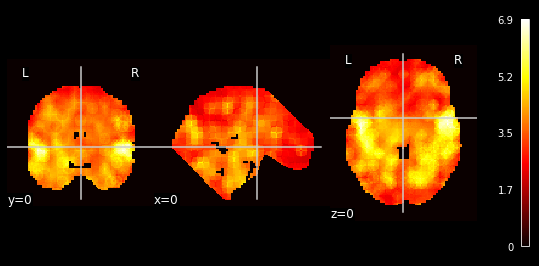

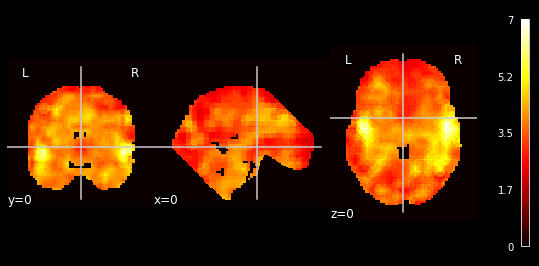

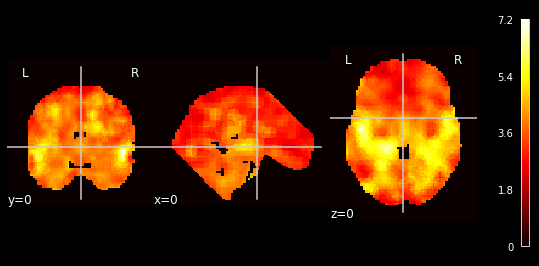

In [13]:
# visualize maps
for i in range(6):
    img = nib.Nifti1Image(vox_map_4d[:,:,:,i].T, affine=template.affine, header=template.header)
    nib.save(img, f'./intact_maps/LL/LL_repeat{i}.nii')

    plotting.plot_img(img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)

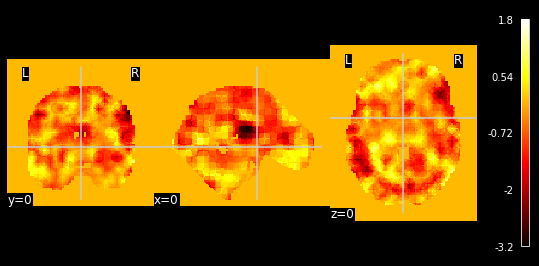

In [14]:
# do one vs. other analysis
OvO_img = one_vs_other(vox_map_4d, template)
plotting.plot_img(OvO_img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)
nib.save(OvO_img , './intact_maps/LL/OvO_LL.nii')

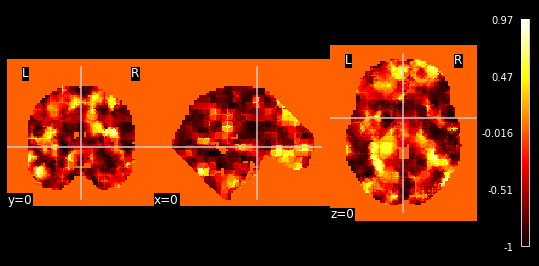

In [15]:
# get correlations between voxel timescales and range[1,6]
corr_img = corr_timescales_range(vox_map_2d, template)
plotting.plot_img(corr_img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)
nib.save(corr_img, './intact_maps/LL/corr_LL.nii')

## WBC

In [16]:
# template
header_fpath = '../data/0407161_predtrw02/filtFuncMNI_Intact_Rep1.nii'
template = nib.load(header_fpath)

# load eWBC.npy file / dictionary 
sl_timescales = np.load('./intact_maps/WBC/WBC.npy', allow_pickle=True).item()

In [18]:
# create 2d voxel map [repeat x voxel]
vox_map_2d = create_2d_vox_map(sl_timescales)

In [19]:
# create 4d voxel map [Z,Y,X,repeat]
vox_map_4d = create_4d_vox_map(vox_map_2d)

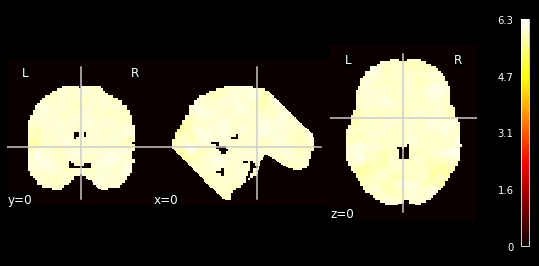

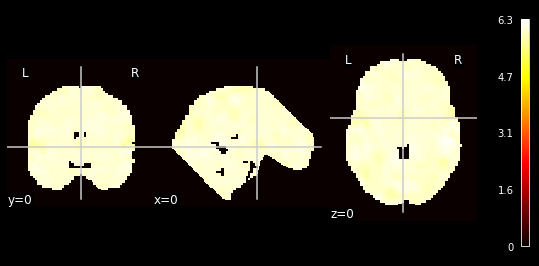

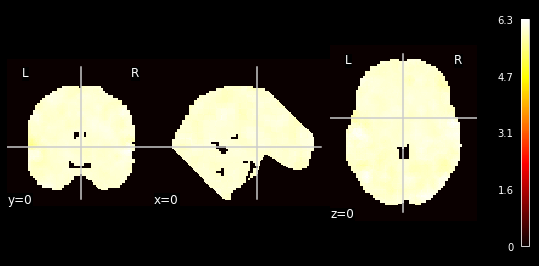

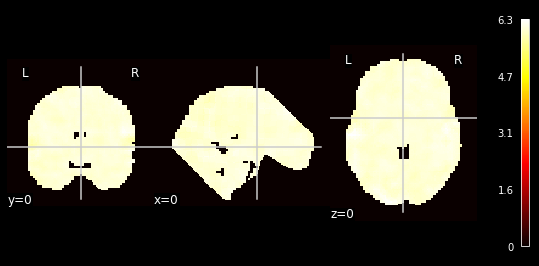

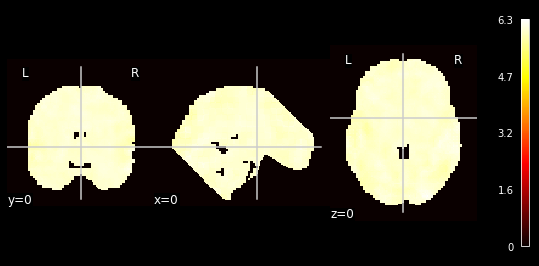

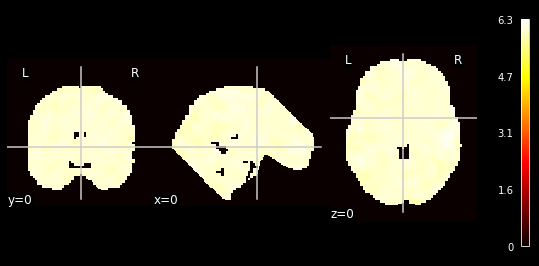

In [20]:
# visualize maps
for i in range(6):
    img = nib.Nifti1Image(vox_map_4d[:,:,:,i].T, affine=template.affine, header=template.header)
    nib.save(img, f'./intact_maps/WBC/WBC_repeat{i}.nii')

    plotting.plot_img(img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], 
                  black_bg=True, colorbar=True)

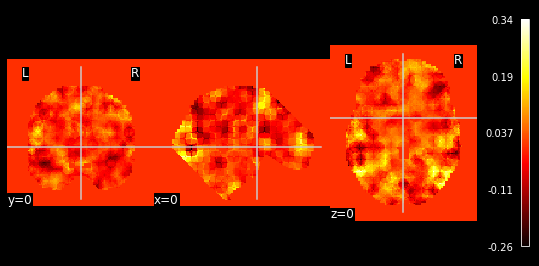

In [21]:
# do one vs. other analysis
OvO_img = one_vs_other(vox_map_4d, template)
plotting.plot_img(OvO_img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)
nib.save(OvO_img , './intact_maps/WBC/OvO_WBC.nii')

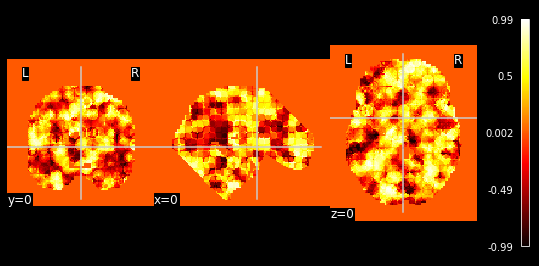

In [22]:
# get correlations between vox timescales and range[1,6]
corr_img = corr_timescales_range(vox_map_2d, template)
plotting.plot_img(corr_img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)
nib.save(corr_img, './intact_maps/WBC/corr_WBC.nii')

# Scrambled

## LL

In [5]:
# template
header_fpath = '../data/0407161_predtrw02/filtFuncMNI_Intact_Rep1.nii'
template = nib.load(header_fpath)

# load eWBC.npy file / dictionary 
sl_timescales = np.load('./scrambled_maps/LL/LL.npy', allow_pickle=True).item()

# create 2d voxel map [repeat, voxel]
vox_map_2d = create_2d_vox_map(sl_timescales)

# create 4d voxel map [Z,Y,X,repeat]
vox_map_4d = create_4d_vox_map(vox_map_2d)

# visualize maps
for i in range(6):
    img = nib.Nifti1Image(vox_map_4d[:,:,:,i].T, affine=template.affine, header=template.header)
    nib.save(img, f'./scrambled_maps/LL/LL_repeat{i}.nii')

    plotting.plot_img(img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)

# do one vs. other analysis
OvO_img = one_vs_other(vox_map_4d, template)
plotting.plot_img(OvO_img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)
nib.save(OvO_img , './scrambled_maps/LL/OvO_LL.nii')

# get correlations between voxel timescales and range[1,6]
corr_img = corr_timescales_range(vox_map_2d, template)
plotting.plot_img(corr_img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)
nib.save(corr_img, './scrambled_maps/LL/corr_LL.nii')

NameError: name 'create_2d_vox_map' is not defined

## WBC

In [ ]:
# template
header_fpath = '../data/0407161_predtrw02/filtFuncMNI_Intact_Rep1.nii'
template = nib.load(header_fpath)

# load eWBC.npy file / dictionary 
sl_timescales = np.load('./scrambled_maps/WBC/WBC.npy', allow_pickle=True).item()

# create 2d voxel map [repeat, voxel]
vox_map_2d = create_2d_vox_map(sl_timescales)

# create 4d voxel map [Z,Y,X,repeat]
vox_map_4d = create_4d_vox_map(vox_map_2d)

# visualize maps
for i in range(6):
    img = nib.Nifti1Image(vox_map_4d[:,:,:,i].T, affine=template.affine, header=template.header)
    nib.save(img, f'./scrambled_maps/WBC/WBC_repeat{i}.nii')

    plotting.plot_img(img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)

# do one vs. other analysis
OvO_img = one_vs_other(vox_map_4d, template)
plotting.plot_img(OvO_img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)
nib.save(OvO_img , './scrambled_maps/WBC/OvO_WBC.nii')

# get correlations between voxel timescales and range[1,6]
corr_img = corr_timescales_range(vox_map_2d, template)
plotting.plot_img(corr_img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)
nib.save(corr_img, './scrambled_maps/WBC/corr_WBC.nii')